### Setup Environment:

In [1]:
from src.get_dataset import split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'diabetes'
TEST_SIZE = 0.7
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 8

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df_train = pd.read_csv(os.path.join(DATASET, 'train_ssl.csv'))
df_test = pd.read_csv(os.path.join(DATASET, 'test_ssl.csv'))

In [4]:
# Map values to categories
#df_train[LABEL] = df_train[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')
#df_test[LABEL] = df_train[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')

Getting validation set...
Train data shape: (5205, 35)
Test data shape: (1302, 35)


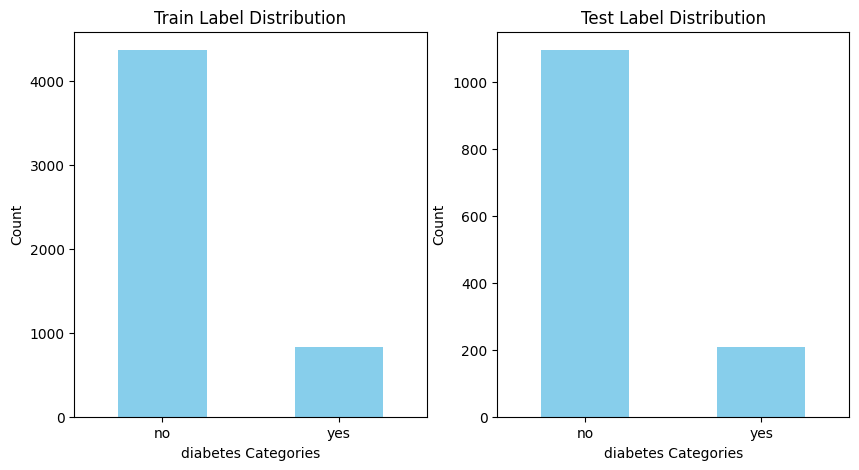

In [5]:
# Split dataset into train, test and validation:
#df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

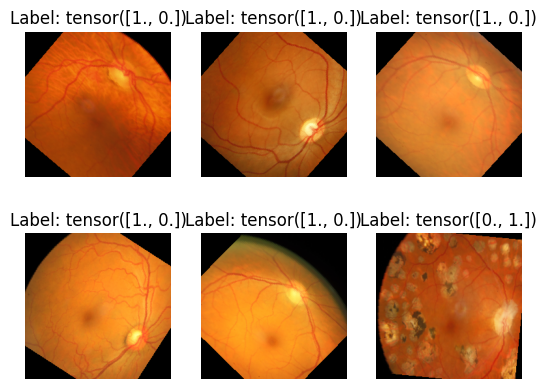

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
# Load backbone weights:
backbone_model.load_state_dict(torch.load('Models/checkpoint_convnextv2_base_byol_v2.pt'))
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 82/82 [00:13<00:00,  6.04it/s]


Epoch 1, Train Loss: 0.6104642677991117, Val Loss: 0.5447992409874753, F1 Score: 0.5350709124832203


100%|██████████| 82/82 [00:13<00:00,  6.04it/s]


Epoch 2, Train Loss: 0.5691062152141431, Val Loss: 0.46972135290866945, F1 Score: 0.6382407364304999


100%|██████████| 82/82 [00:13<00:00,  6.19it/s]


Epoch 3, Train Loss: 0.5507590170277924, Val Loss: 0.4654983858146319, F1 Score: 0.577206572769953


100%|██████████| 82/82 [00:13<00:00,  6.08it/s]


Epoch 4, Train Loss: 0.5400859110912338, Val Loss: 0.45706547378766826, F1 Score: 0.6315961017052354


100%|██████████| 82/82 [00:13<00:00,  6.13it/s]


Epoch 5, Train Loss: 0.5421118004400222, Val Loss: 0.4975795393309942, F1 Score: 0.5789045383411581


100%|██████████| 82/82 [00:13<00:00,  6.06it/s]


Epoch 6, Train Loss: 0.5251247119097436, Val Loss: 0.4707044170397084, F1 Score: 0.6644442247004843


100%|██████████| 82/82 [00:13<00:00,  6.17it/s]


Epoch 7, Train Loss: 0.5165578924730175, Val Loss: 0.4805599712743992, F1 Score: 0.6395307683525516


100%|██████████| 82/82 [00:13<00:00,  6.11it/s]


Epoch 8, Train Loss: 0.5127581529685709, Val Loss: 0.47534956474129747, F1 Score: 0.6664063344086186


100%|██████████| 82/82 [00:13<00:00,  5.95it/s]


Epoch 9, Train Loss: 0.5104439317202959, Val Loss: 0.4748833035913909, F1 Score: 0.6641509923718613


100%|██████████| 82/82 [00:13<00:00,  6.10it/s]


Epoch 10, Train Loss: 0.5261414301932835, Val Loss: 0.5106644883024983, F1 Score: 0.6648892773892774


100%|██████████| 82/82 [00:13<00:00,  6.03it/s]


Epoch 11, Train Loss: 0.490372968868154, Val Loss: 0.46330540554552546, F1 Score: 0.7110997622611606


100%|██████████| 82/82 [00:13<00:00,  6.09it/s]


Epoch 12, Train Loss: 0.47993710685948854, Val Loss: 0.46644344907708285, F1 Score: 0.6872325201035845


100%|██████████| 82/82 [00:14<00:00,  5.85it/s]


Epoch 13, Train Loss: 0.4699619029755475, Val Loss: 0.44879548669588276, F1 Score: 0.7056570189335757


100%|██████████| 82/82 [00:13<00:00,  6.06it/s]


Epoch 14, Train Loss: 0.46099142317400604, Val Loss: 0.4269500583773706, F1 Score: 0.7048620439525012


100%|██████████| 82/82 [00:13<00:00,  6.09it/s]


Epoch 15, Train Loss: 0.44240177318942353, Val Loss: 0.47226834924119276, F1 Score: 0.709521603680013


100%|██████████| 82/82 [00:13<00:00,  6.19it/s]


Epoch 16, Train Loss: 0.43564376557459594, Val Loss: 0.44142897926816127, F1 Score: 0.7126099706744868


100%|██████████| 82/82 [00:13<00:00,  6.13it/s]


Epoch 17, Train Loss: 0.4295727639413271, Val Loss: 0.43713022768497467, F1 Score: 0.7010495029928854


100%|██████████| 82/82 [00:13<00:00,  6.15it/s]


Epoch 18, Train Loss: 0.4240234395519632, Val Loss: 0.4211050377386372, F1 Score: 0.7212716689055204


100%|██████████| 82/82 [00:13<00:00,  6.13it/s]


Epoch 19, Train Loss: 0.40235616403524993, Val Loss: 0.5543627855254383, F1 Score: 0.7247740105137264


100%|██████████| 82/82 [00:13<00:00,  6.08it/s]


Epoch 20, Train Loss: 0.39746280697281244, Val Loss: 0.4411548360637048, F1 Score: 0.738251328881014


100%|██████████| 82/82 [00:13<00:00,  6.21it/s]


Epoch 21, Train Loss: 0.3919527113926215, Val Loss: 0.6132838500709068, F1 Score: 0.5442205688745031


100%|██████████| 82/82 [00:13<00:00,  6.12it/s]


Epoch 22, Train Loss: 0.3805694512900759, Val Loss: 0.47075350291845275, F1 Score: 0.6978261430155497


100%|██████████| 82/82 [00:13<00:00,  6.19it/s]


Epoch 23, Train Loss: 0.36402434328051864, Val Loss: 0.44659684316777604, F1 Score: 0.7234413368895083


100%|██████████| 82/82 [00:13<00:00,  6.23it/s]


Epoch 24, Train Loss: 0.34874632132590794, Val Loss: 0.4598276928612372, F1 Score: 0.74300923420032


100%|██████████| 82/82 [00:13<00:00,  6.18it/s]


Epoch 25, Train Loss: 0.3523153276533866, Val Loss: 0.4841202930433721, F1 Score: 0.7548103755054618


100%|██████████| 82/82 [00:13<00:00,  6.25it/s]


Epoch 26, Train Loss: 0.31984986538281207, Val Loss: 0.520339941424204, F1 Score: 0.7489952119665886


100%|██████████| 82/82 [00:13<00:00,  6.10it/s]


Epoch 27, Train Loss: 0.30453848064434336, Val Loss: 0.4939345588862169, F1 Score: 0.743586971212326


100%|██████████| 82/82 [00:13<00:00,  6.05it/s]


Epoch 28, Train Loss: 0.32096667959064734, Val Loss: 0.5645357870110651, F1 Score: 0.7420021773176975


100%|██████████| 82/82 [00:13<00:00,  5.96it/s]


Epoch 29, Train Loss: 0.285392775594211, Val Loss: 0.5126464162930483, F1 Score: 0.7451810349789896


100%|██████████| 82/82 [00:13<00:00,  6.07it/s]


Epoch 30, Train Loss: 0.26614790750575845, Val Loss: 0.5615554839917799, F1 Score: 0.7511300621744246


100%|██████████| 82/82 [00:13<00:00,  6.11it/s]


Epoch 31, Train Loss: 0.2588059810432987, Val Loss: 0.5232340560817137, F1 Score: 0.7487564322469983


100%|██████████| 82/82 [00:13<00:00,  6.18it/s]


Epoch 32, Train Loss: 0.2427260142491489, Val Loss: 0.6776900789359721, F1 Score: 0.7458249213364617
Early stopping triggered.


### Test

100%|██████████| 326/326 [00:47<00:00,  6.80it/s]


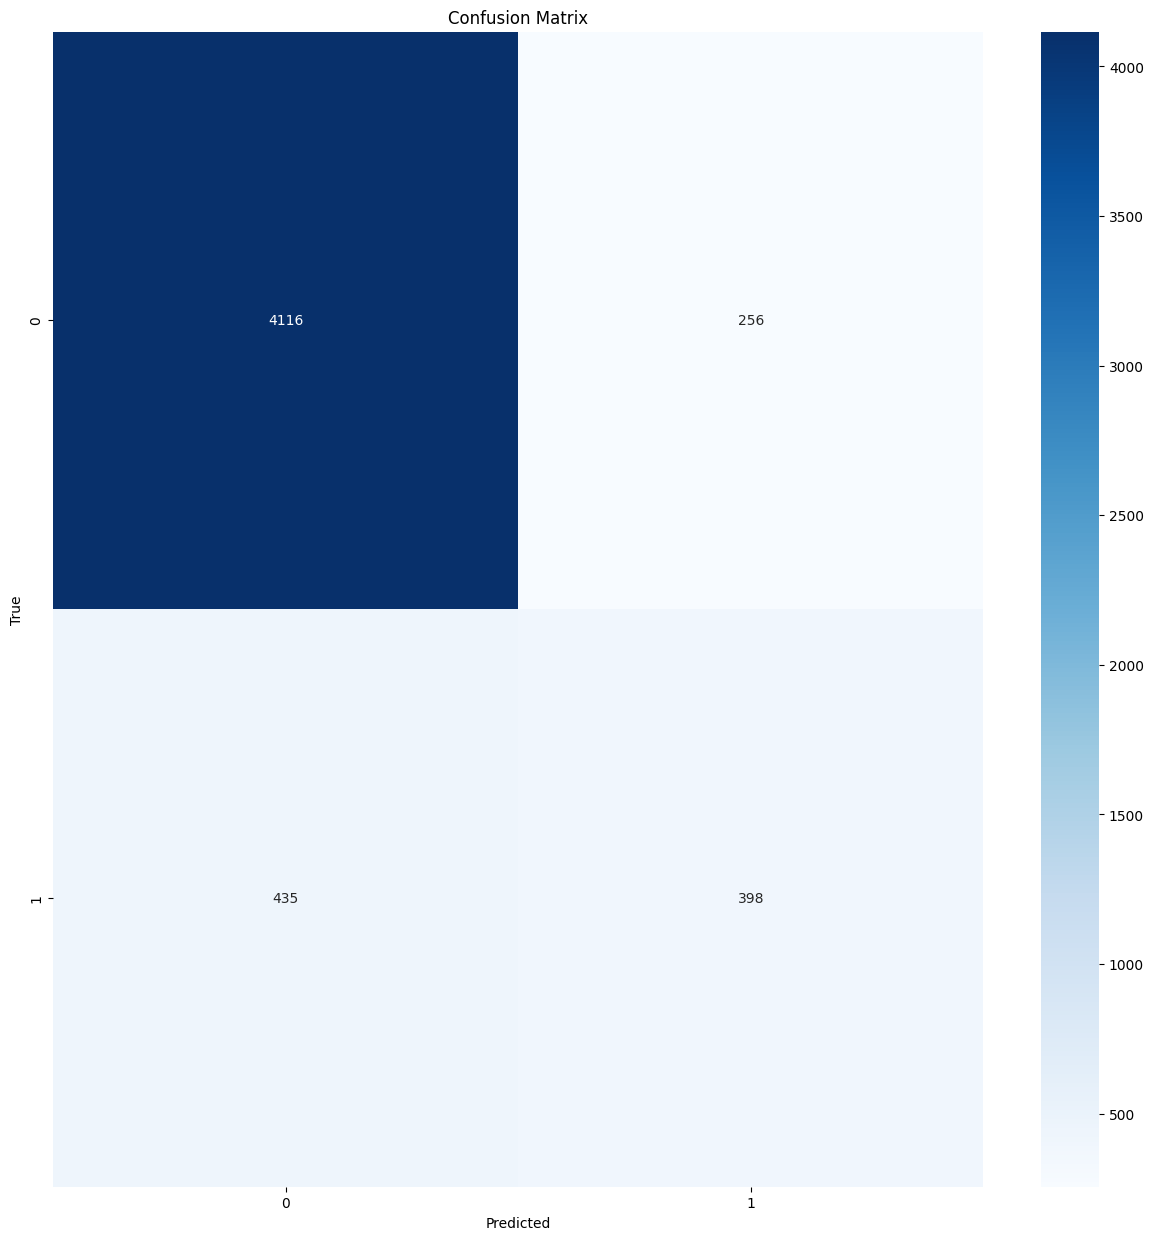

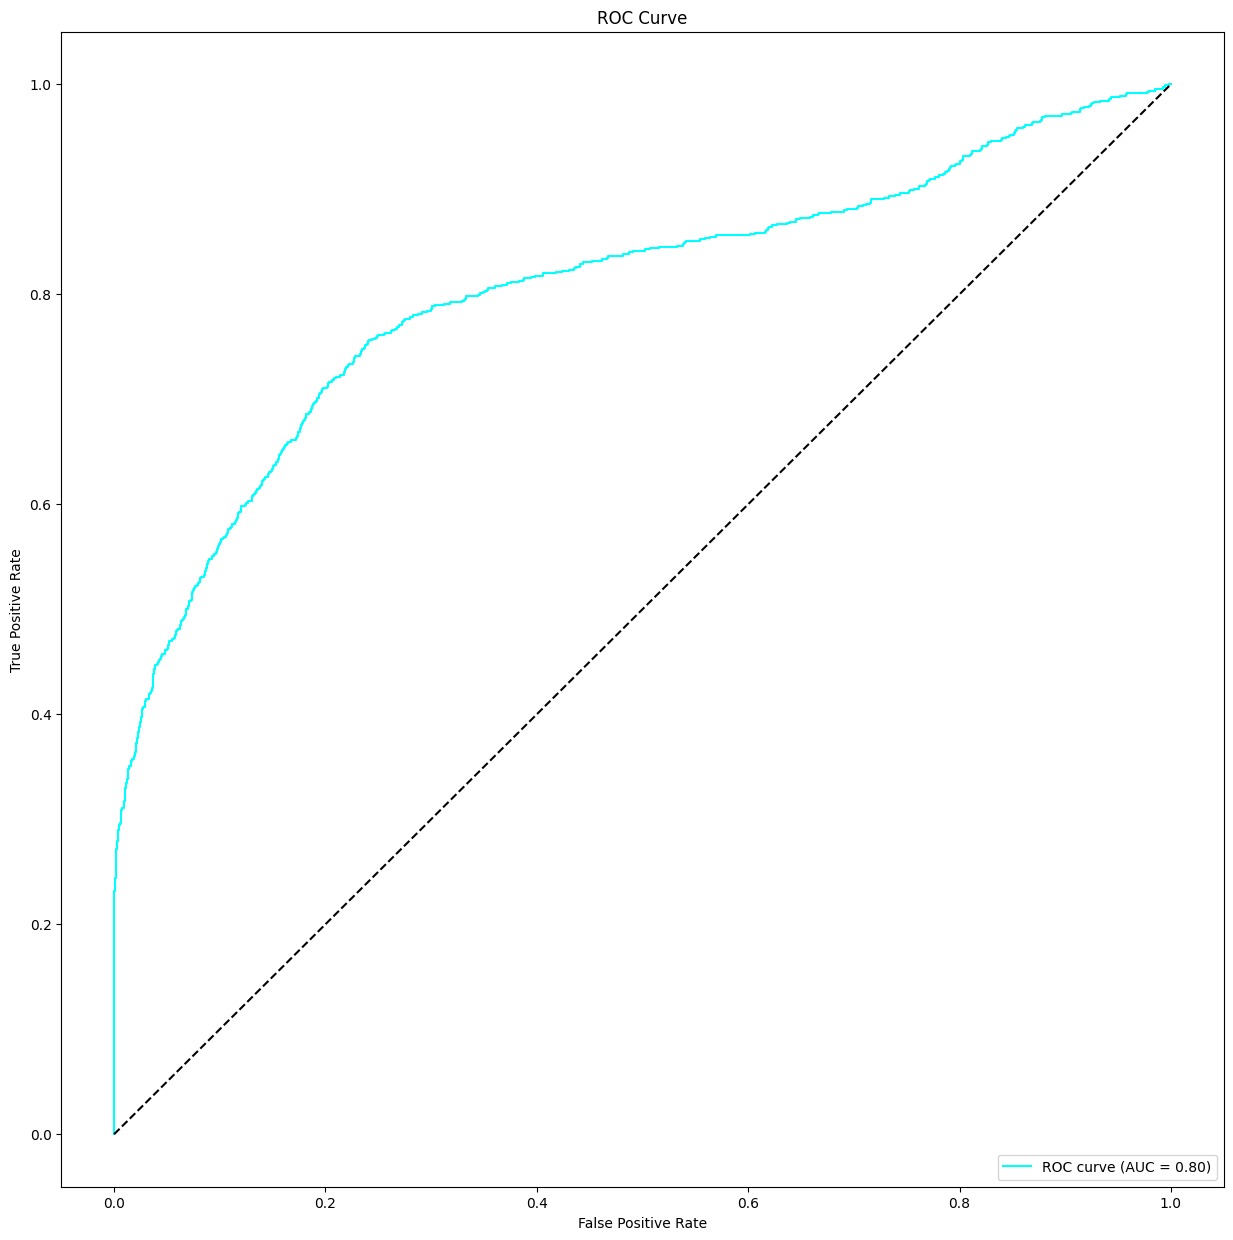

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4372
           1       0.61      0.48      0.54       833

    accuracy                           0.87      5205
   macro avg       0.76      0.71      0.73      5205
weighted avg       0.86      0.87      0.86      5205

##################################################  Saliency Maps  ##################################################

Class 0:


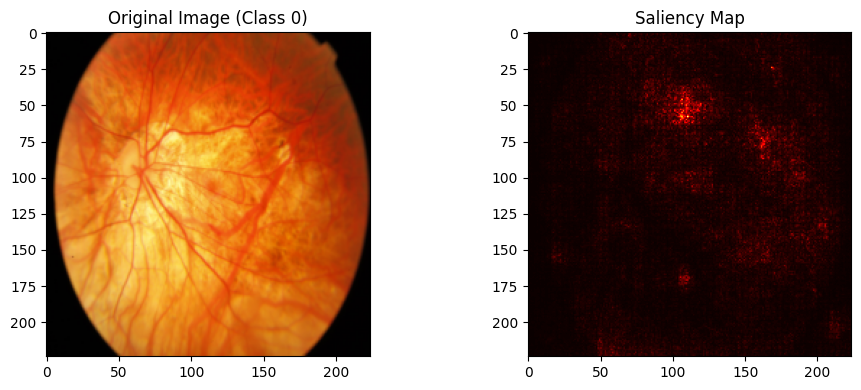

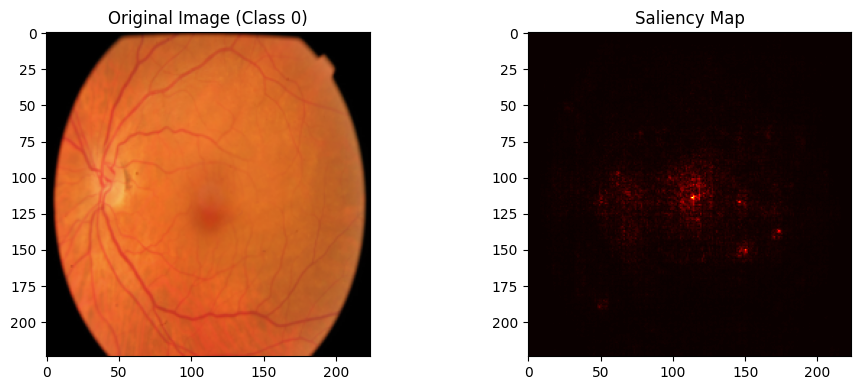

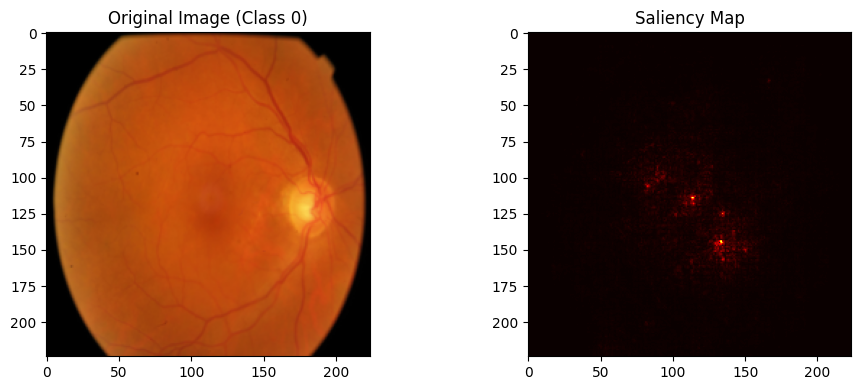

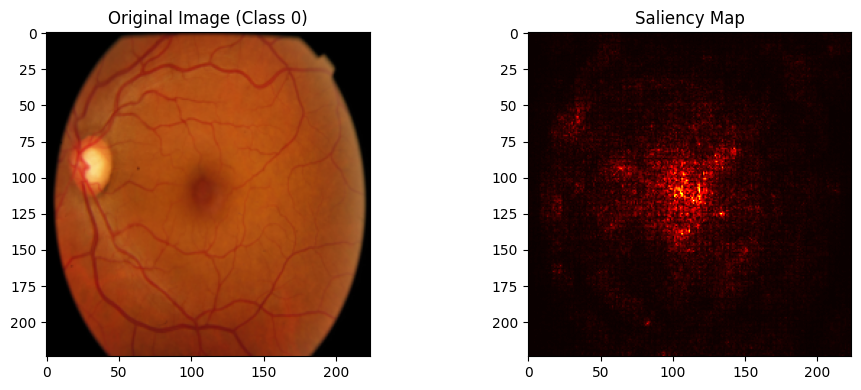

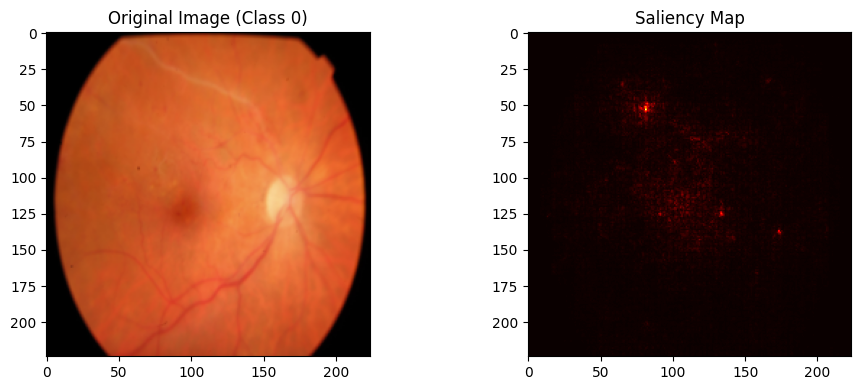

Class 1:


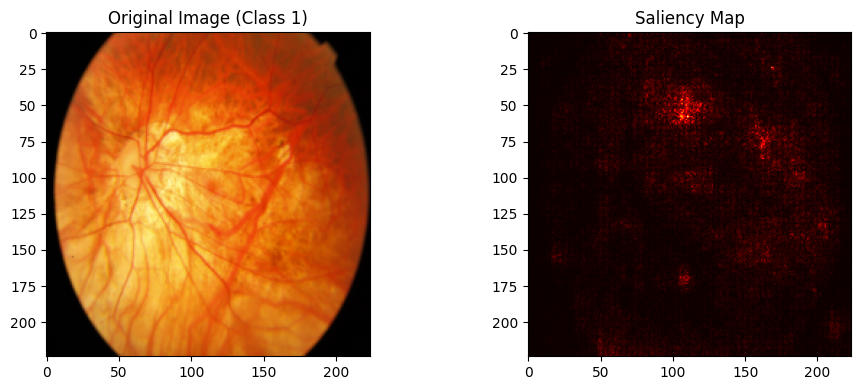

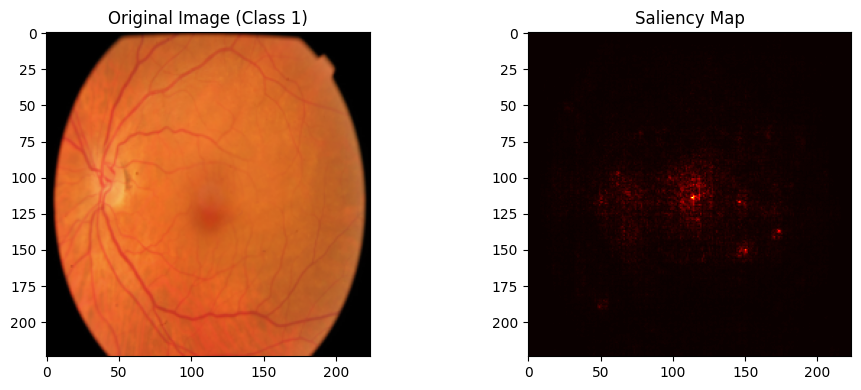

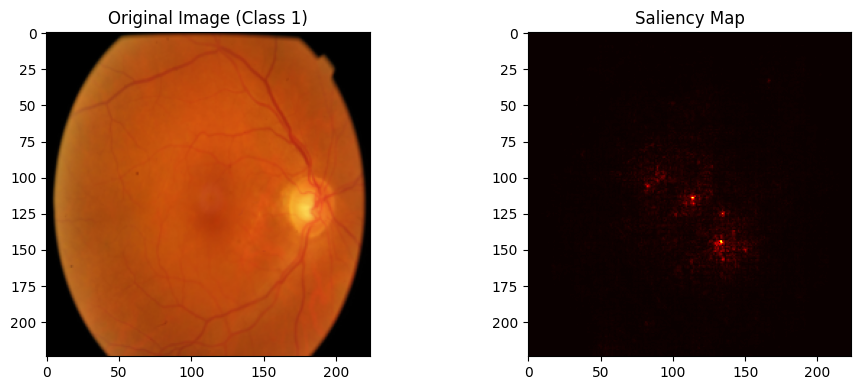

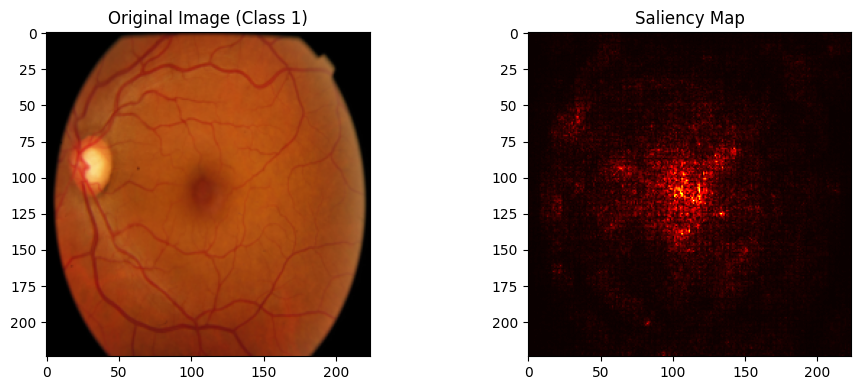

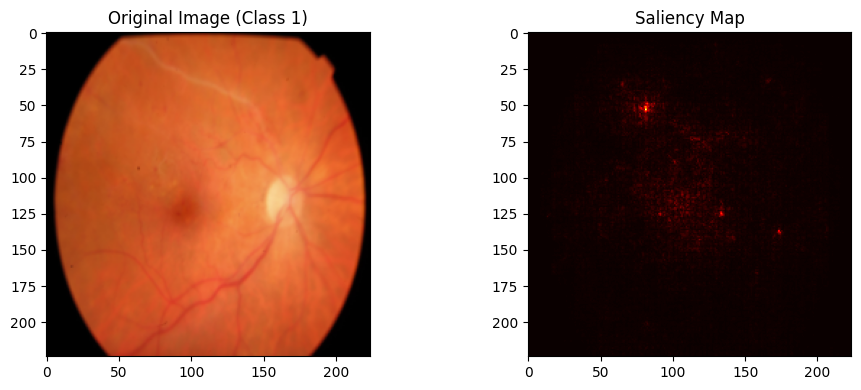

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 287/287 [00:42<00:00,  6.81it/s]


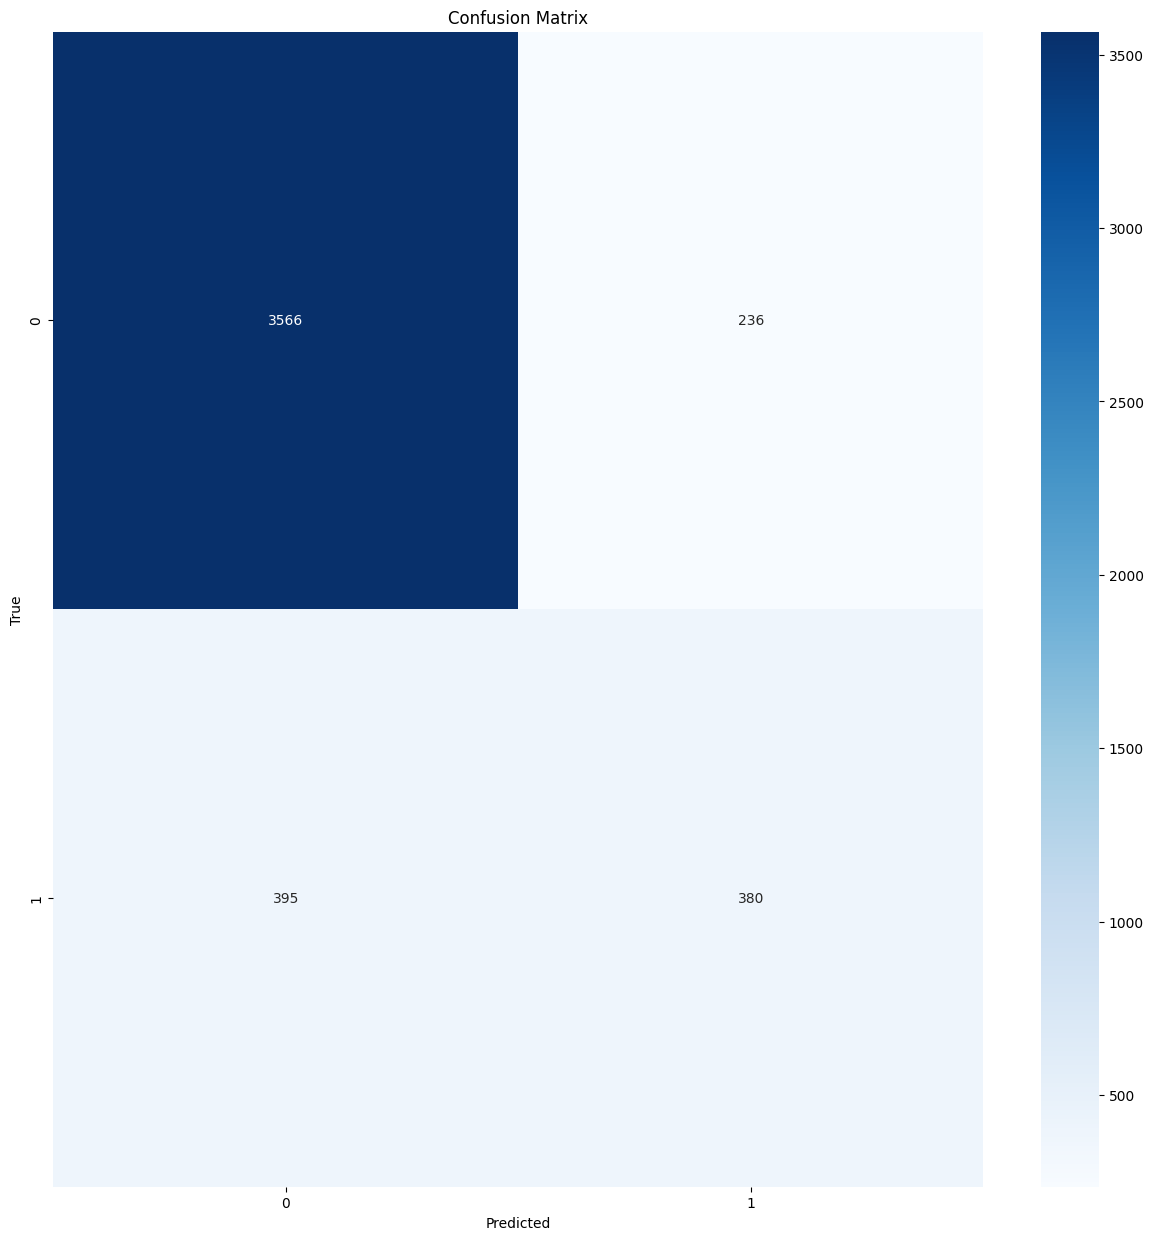

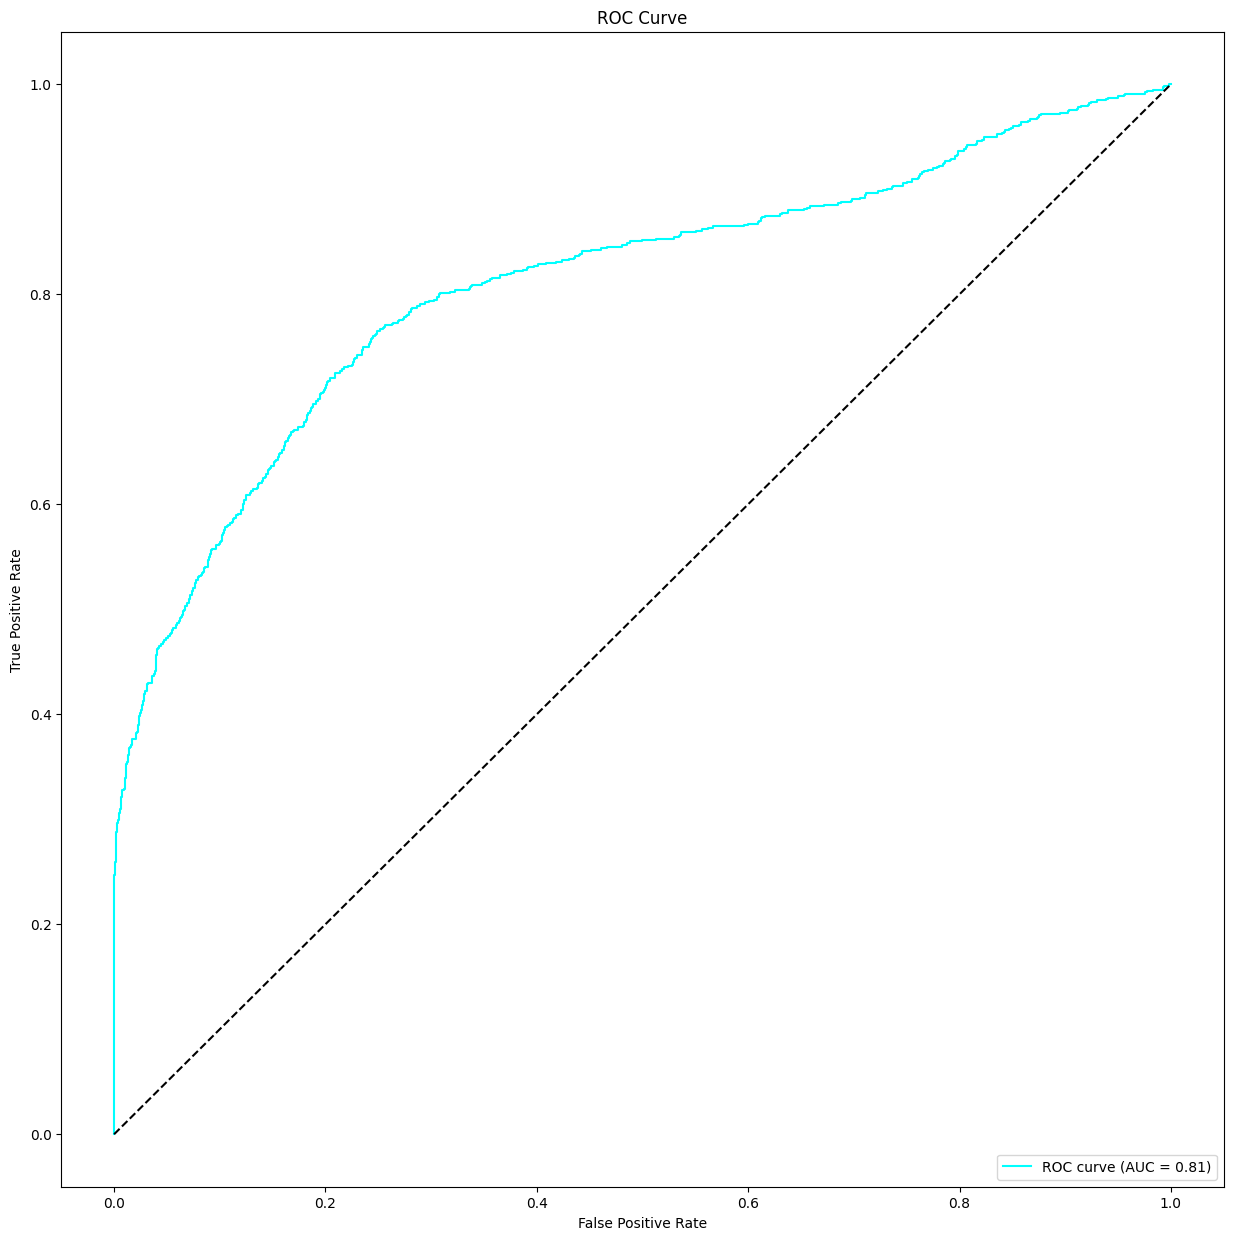

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3802
           1       0.62      0.49      0.55       775

    accuracy                           0.86      4577
   macro avg       0.76      0.71      0.73      4577
weighted avg       0.85      0.86      0.86      4577

##################################################  Saliency Maps  ##################################################

Class 0:


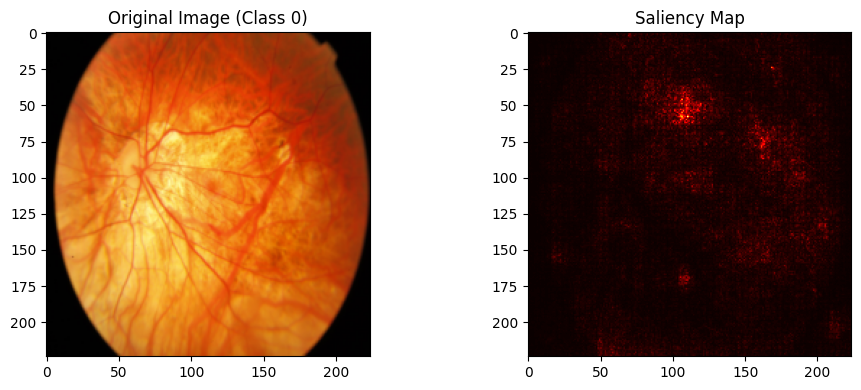

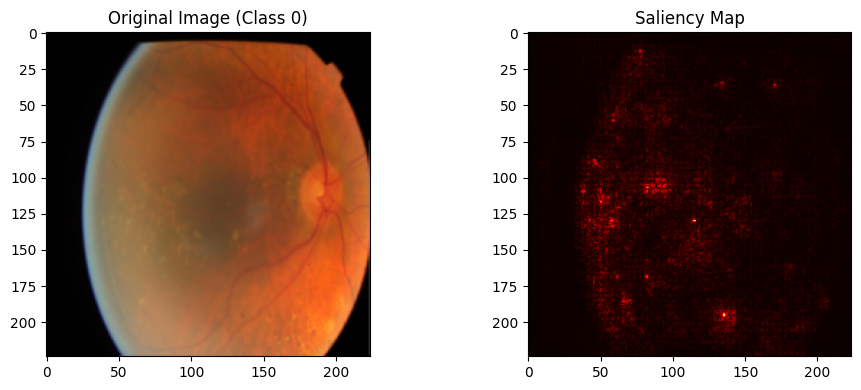

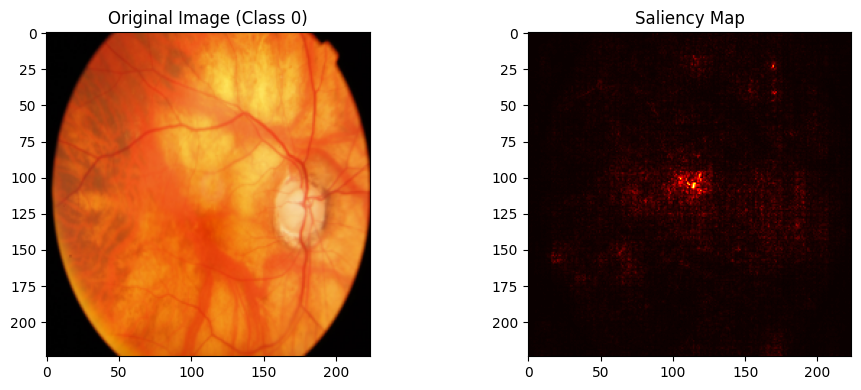

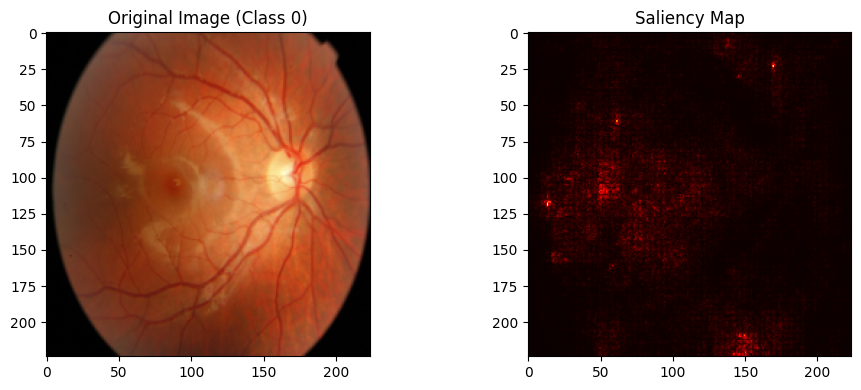

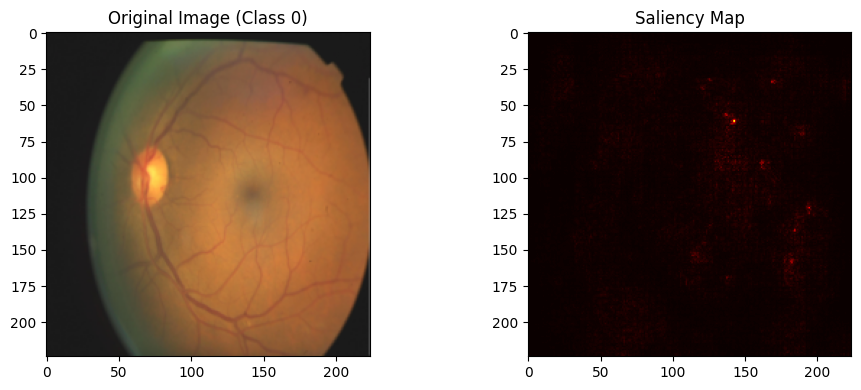

Class 1:


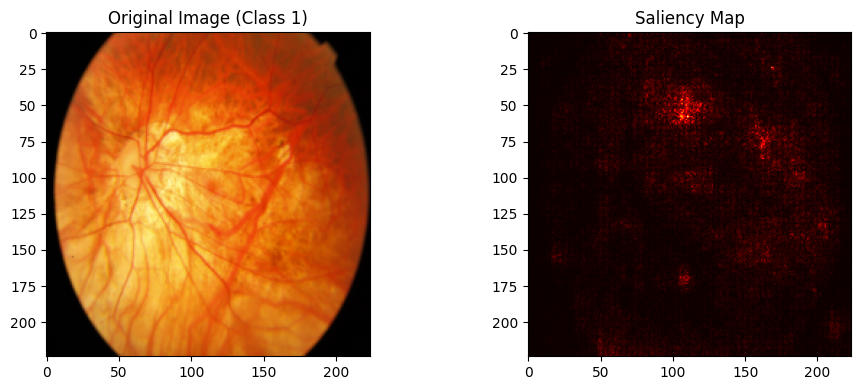

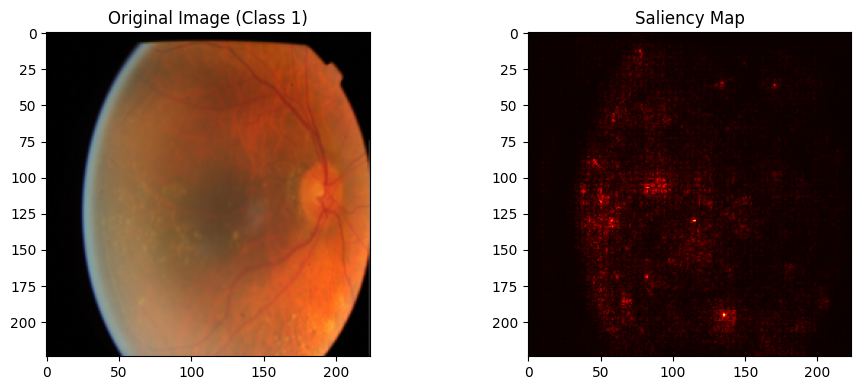

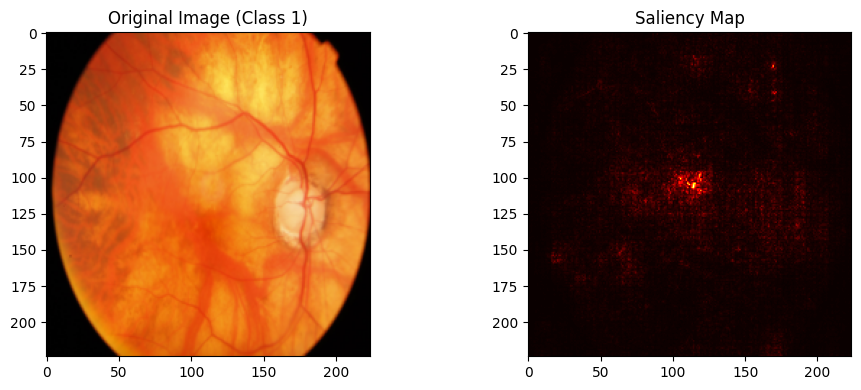

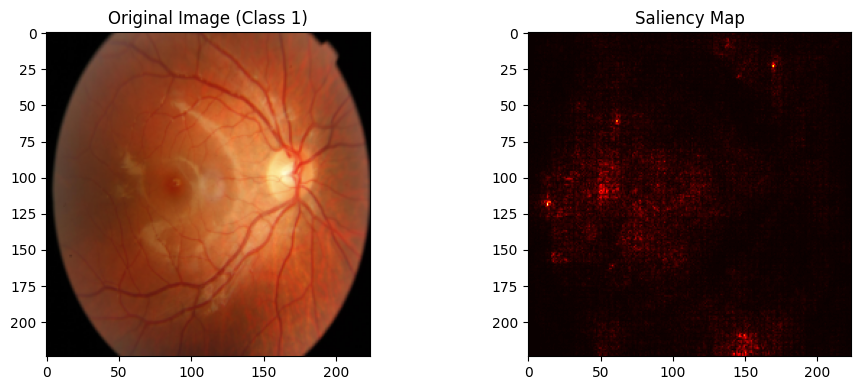

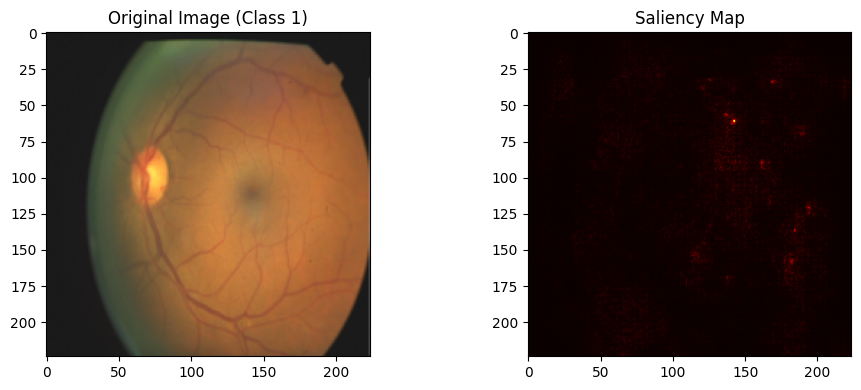

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


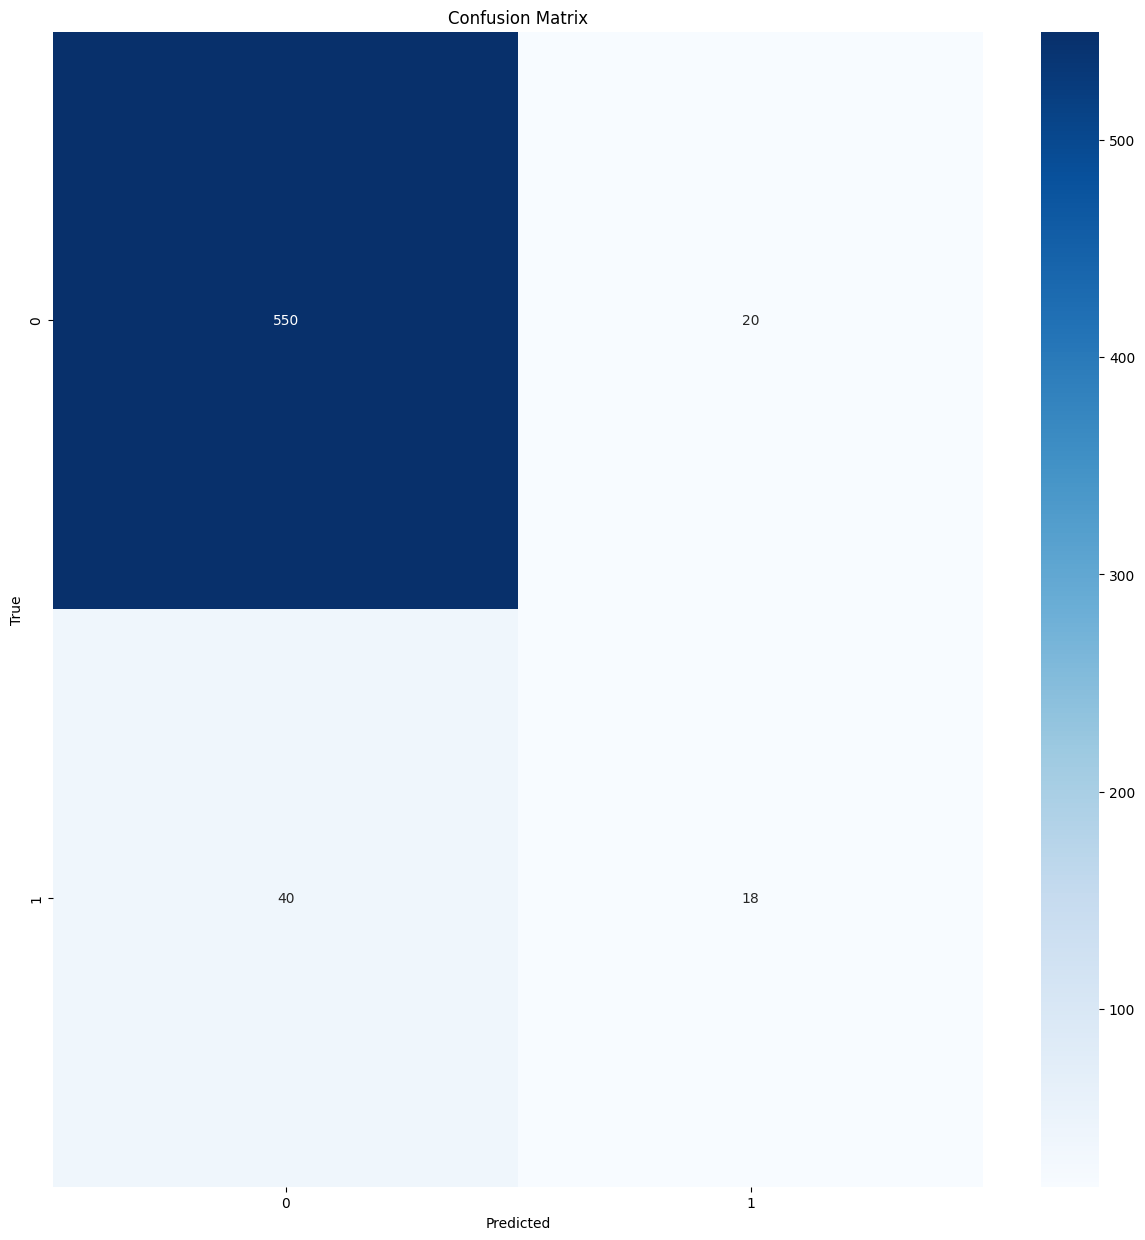

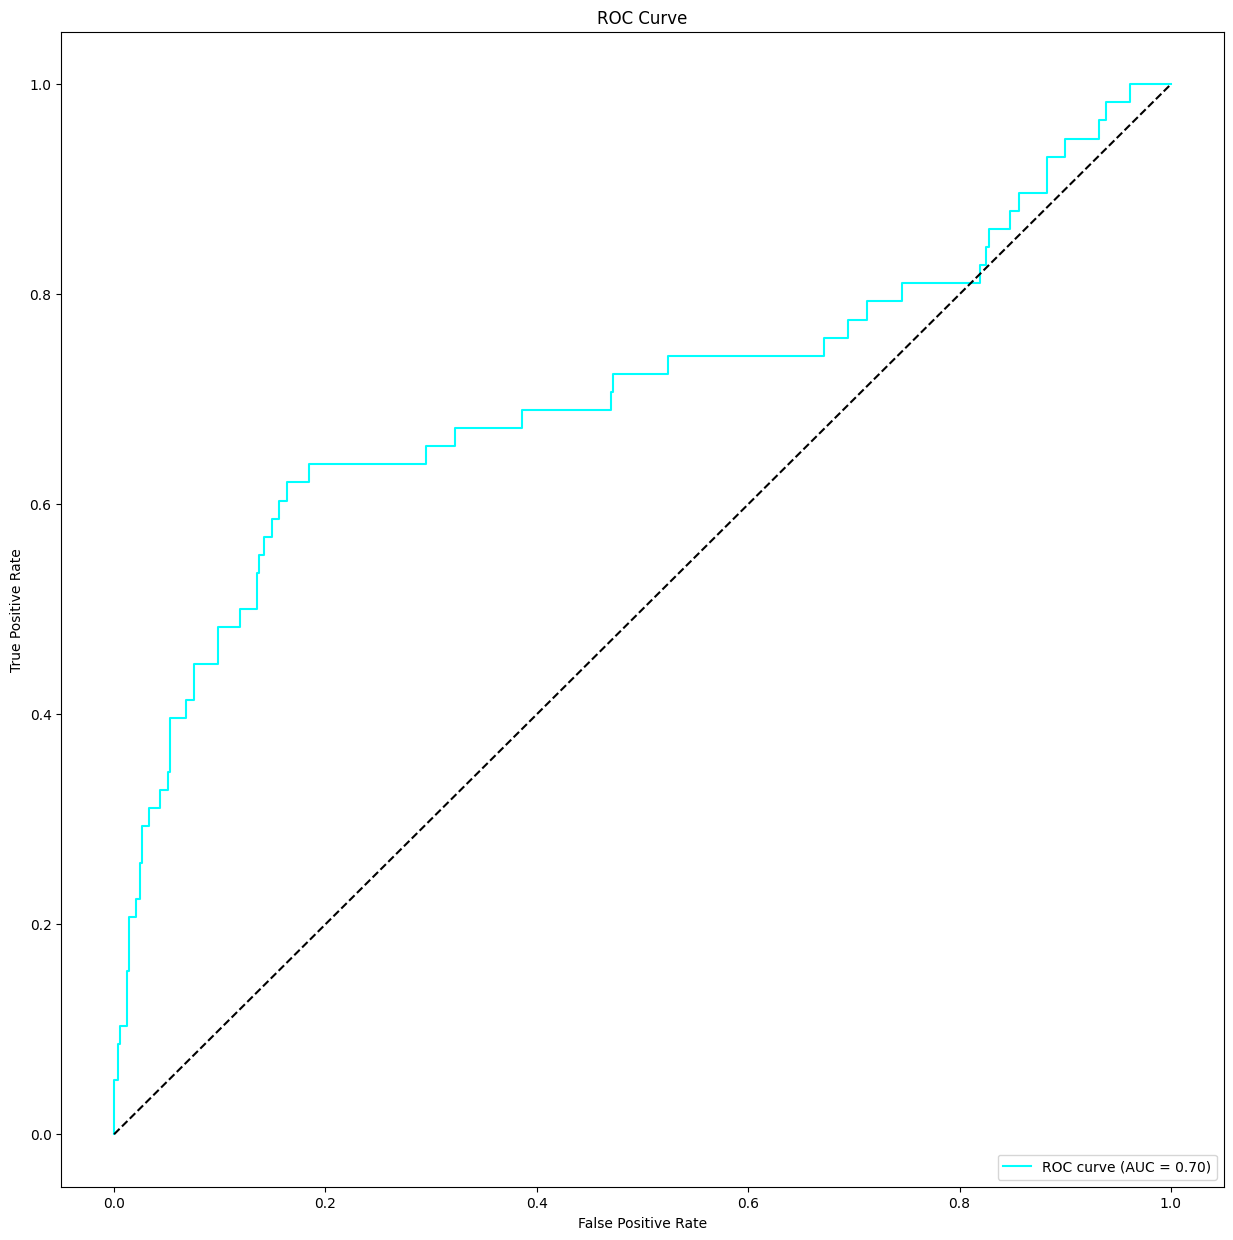

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       570
           1       0.47      0.31      0.38        58

    accuracy                           0.90       628
   macro avg       0.70      0.64      0.66       628
weighted avg       0.89      0.90      0.90       628

##################################################  Saliency Maps  ##################################################

Class 0:


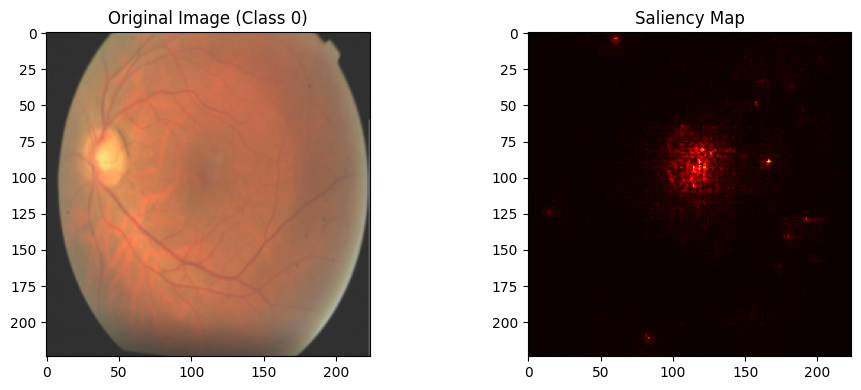

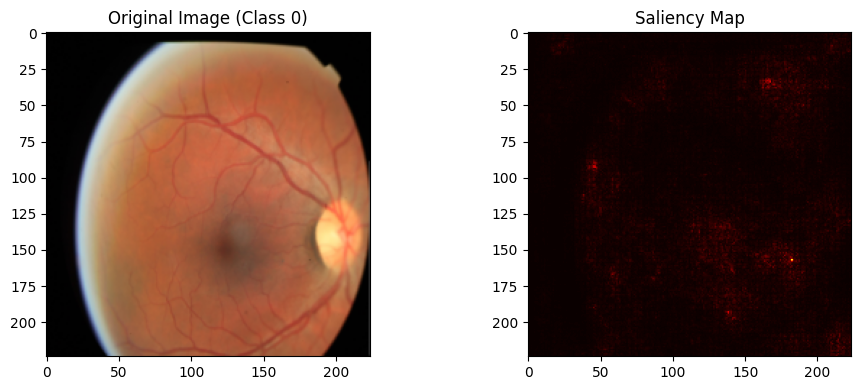

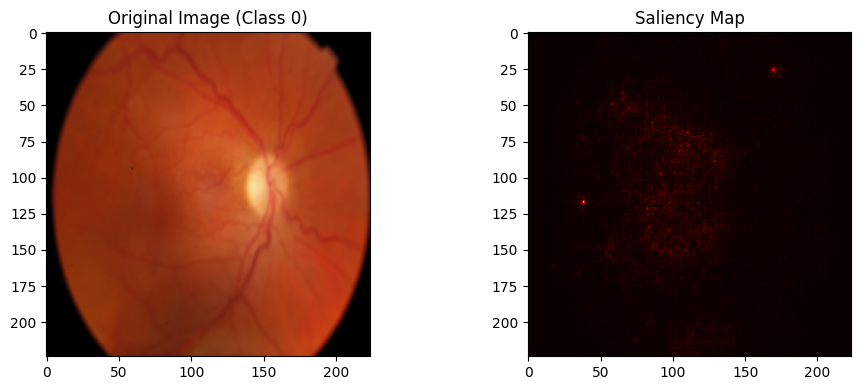

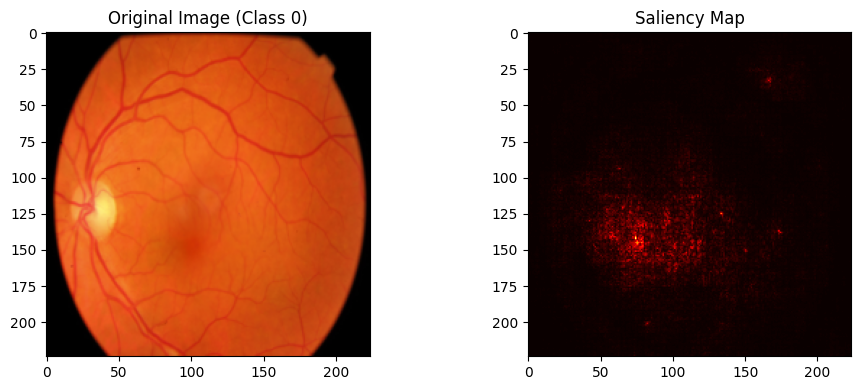

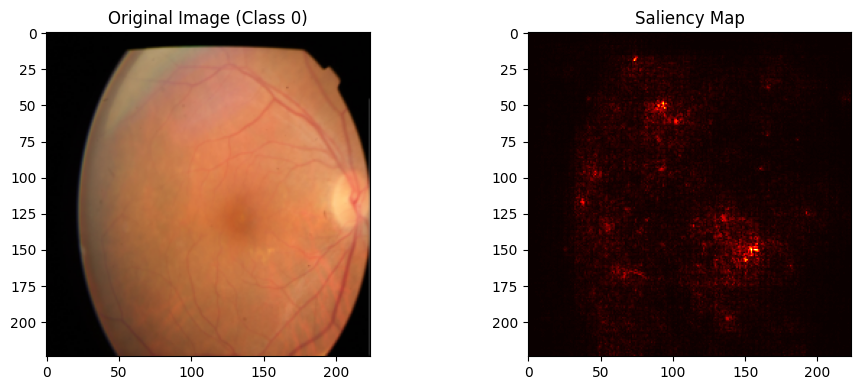

Class 1:


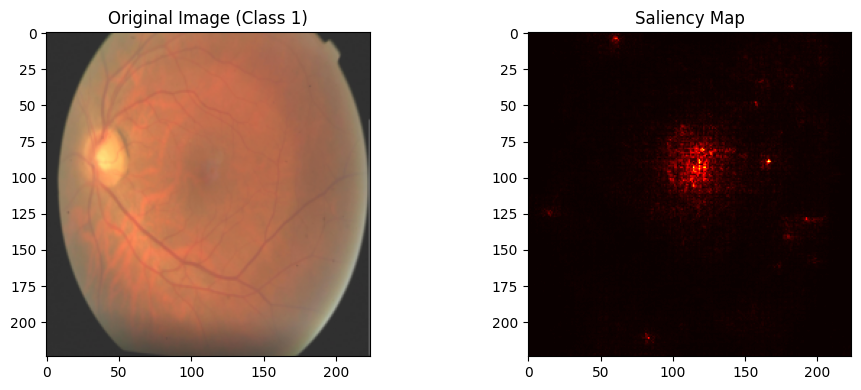

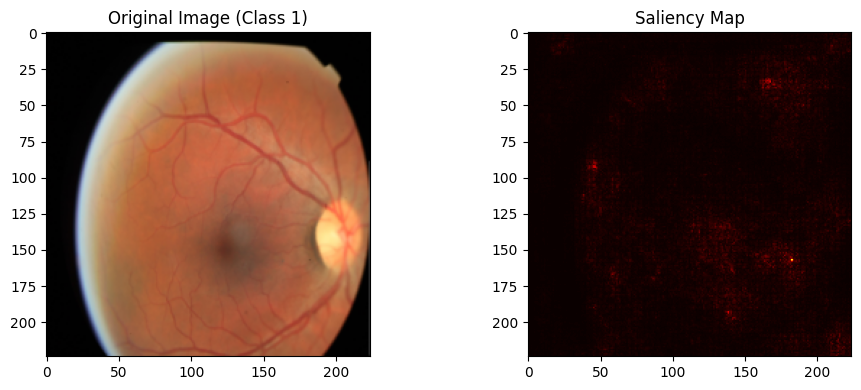

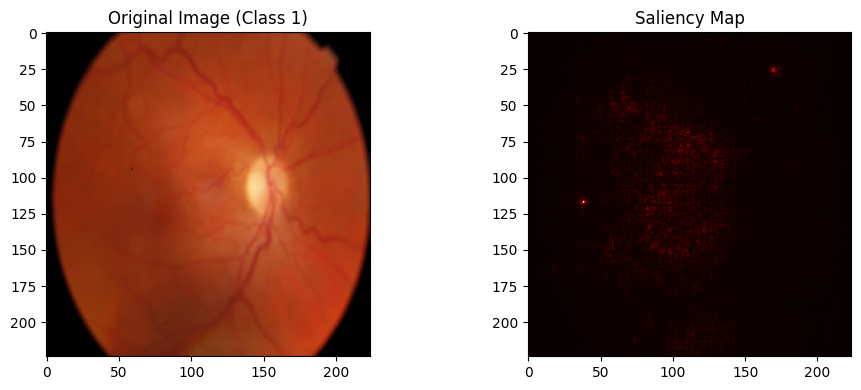

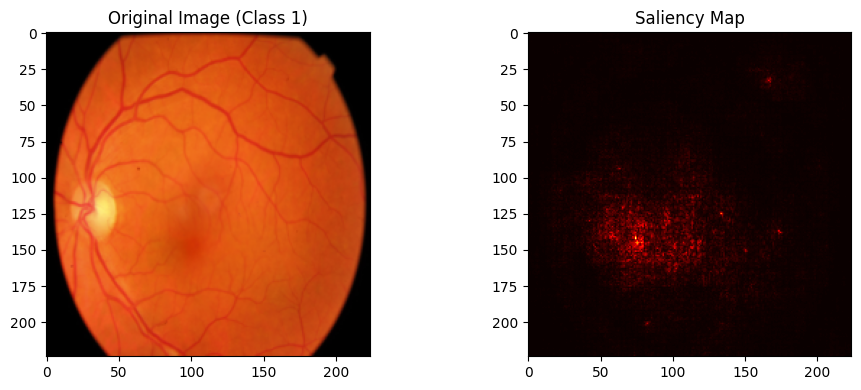

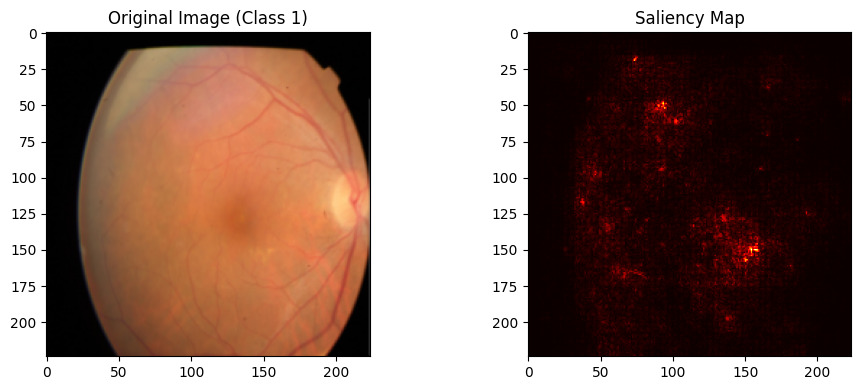

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)